In [1]:
import numpy as np
import torch
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

font = {'family' : 'Liberation Sans',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

In [2]:
import sys
sys.path.insert(0, './python')

from windkessel import model

In [3]:
from scipy.integrate import solve_ivp

In [4]:
test_model = model.WindkesselModel()
test_model.R     = 870
test_model.Z_0   = 0
test_model.C     = 1e-3
test_model.P_out = 0

In [5]:
def P_rhs(t, P):
    return test_model.P_rhs(t, P)#.detach().numpy()

In [6]:
params = {
    "T_max": 0.09,
    "T_S": 0.33,
    "t_d": 0.35,
    "T": 0.9,
    "Q_max": 0.37,
    "C_sa": 1e-3,
    "R_S": 870,
    "R_f": 0.3,
}

In [7]:
def article_Q_LA(t, T_max, T_S, t_d, T, Q_max, C_sa, R_S, R_f):
    while t < 0:
        t += T
    while t > T:
        t -= T
    if 0 <= t and t <= T_max:
        return 0.5 * Q_max * (np.sin(np.pi * (t - T_max / 2) / T_max) + 1)
    elif T_max <= t and t <= T_S:
        return 0.5 * Q_max * (np.cos(np.pi * (t - T_max) / (T_S - T_max)) + 1)
    elif T_S <= t and t <= T:
        return 0.0
    
def article_Q(t, T_max, T_S, t_d, T, Q_max, C_sa, R_S, R_f):
    ans = article_Q_LA(t, T_max, T_S, t_d, T, Q_max, C_sa, R_S, R_f) + \
            R_f * article_Q_LA(t - t_d, T_max, T_S, t_d, T, Q_max, C_sa, R_S, R_f)
    
    return ans

In [8]:
T = np.linspace(0, params["T"], 101)

Q = np.zeros_like(T)
for i in range(len(Q)):
    Q[i] = article_Q(T[i], **params)
    
test_model.set_Q_in(T, Q)

In [9]:
n_cycles = 10
new_T = np.linspace(T[0], T[0] + n_cycles * (T[-1] - T[0]), n_cycles * (T.shape[0] - 1) + 1)

In [10]:
max_dt = (T[-1] - T[0]) / 100
result = solve_ivp(P_rhs, (new_T[0], new_T[-1]), np.array([66.0]),
                   t_eval=new_T, max_step=max_dt, rtol=1.0)

In [11]:
P = result.y[0]

In [12]:
def plot_x_y(x, y):
    fig = plt.figure()
    ax = fig.gca()
    fig.set_figheight(8)
    fig.set_figwidth(16)
    ax.grid(color='#000000', alpha=0.15, linestyle='-', linewidth=1, which='major')
    ax.grid(color='#000000', alpha=0.1, linestyle='-', linewidth=0.5, which='minor')
    
    ax.plot(x,y)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.show()

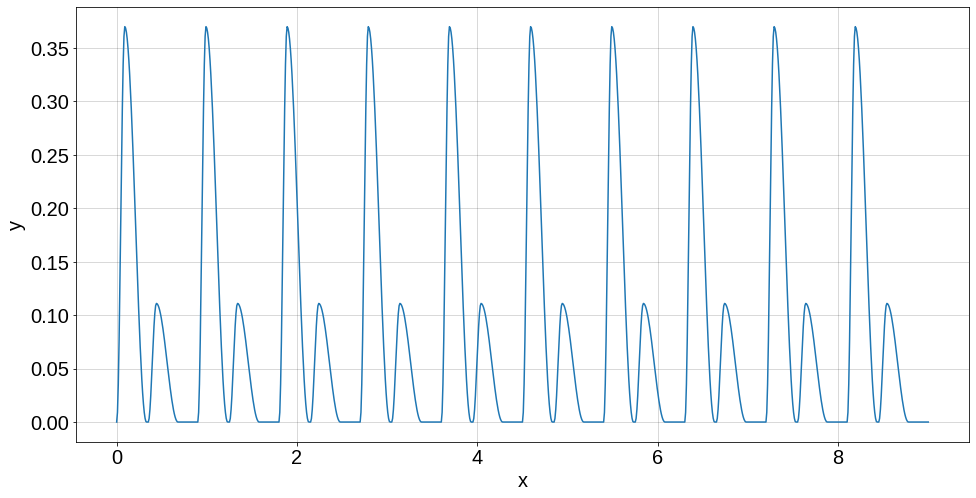

In [13]:
plot_x_y(new_T, np.array([test_model.get_Q_in(t) for t in new_T]))

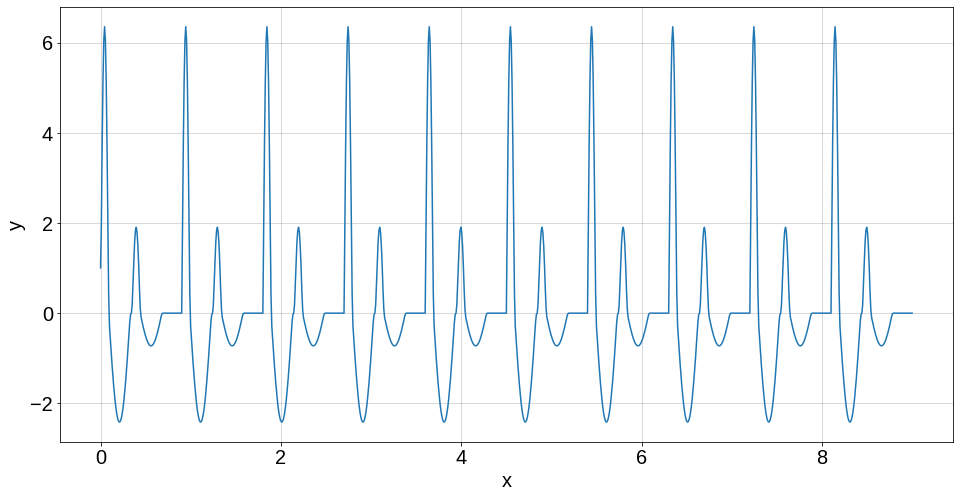

In [14]:
plot_x_y(new_T, np.array([test_model.get_der_Q_in(t) for t in new_T]))

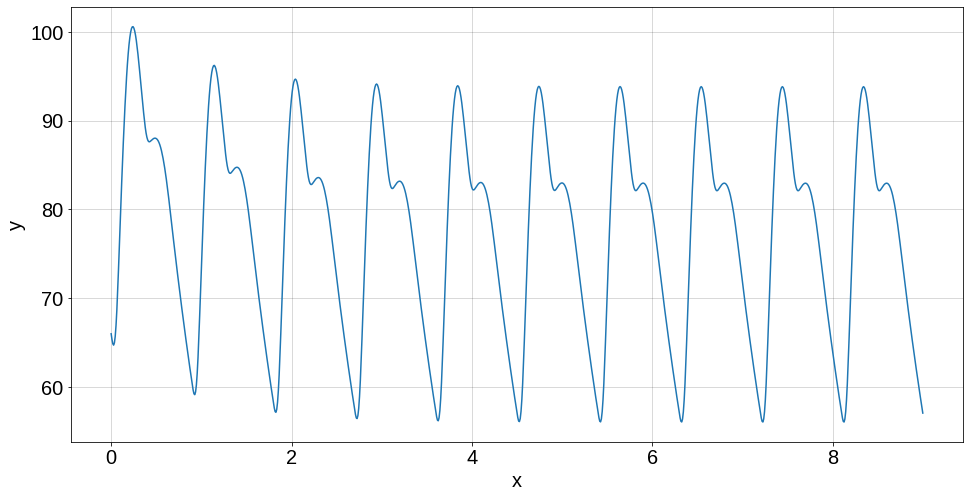

In [15]:
plot_x_y(new_T, P)